In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn import linear_model, svm
from sklearn.metrics import make_scorer, r2_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
#import tflearn
#import tensorflow as tf
import seaborn
#import warnings
#warnings.filterwarnings('ignore')

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

In [27]:
data = pd.read_csv('train.csv')
labels = data['SalePrice']
data = data.drop("SalePrice", axis = 1)

In [28]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [29]:
nans = pd.isnull(data).sum()
nans[nans > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [30]:
# Remove id and columns with more than 500 missing values
data = data.drop("Id", 1)
data = data.drop("PoolQC", 1)
data = data.drop("MiscFeature", 1)
data = data.drop("Alley", 1)
data = data.drop("Fence", 1)
data = data.drop("FireplaceQu", 1)

In [31]:
# Count the column types
data.dtypes.value_counts()

object     38
int64      33
float64     3
dtype: int64

In [32]:
all_columns = data.columns.values

numerical_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
                     'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
                      'GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                     '3SsnPorch','ScreenPorch','PoolArea','MiscVal']

categorical_features = [value for value in all_columns if value not in numerical_features]

In [33]:
# One Hot Encoding and nan transformation
data = pd.get_dummies(data)

imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
data = imp.fit_transform(data)

# Log transformation
data = np.log(data)
labels = np.log(labels)

# Change -inf to 0 again
data[data==-np.inf]=0

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


Feature reduction
There are many features, so I am going to use PCA to reduce them. The idea is to start with n_components = number of columns. Then select the number of components that add up to 1 variance_ratio.

In [34]:
pca = PCA(whiten=True)
pca.fit(data)
variance = pd.DataFrame(pca.explained_variance_ratio_)
np.cumsum(pca.explained_variance_ratio_)

array([0.22421051, 0.40227814, 0.52596656, 0.62863801, 0.70150044,
       0.76077132, 0.81268873, 0.85679338, 0.88941298, 0.9198445 ,
       0.94553939, 0.95506589, 0.9641389 , 0.97217505, 0.97959301,
       0.98467641, 0.98879319, 0.99192101, 0.99392843, 0.9952653 ,
       0.99621772, 0.99704971, 0.99778375, 0.99846264, 0.99897294,
       0.99937421, 0.99961794, 0.99980127, 0.99988475, 0.99994181,
       0.99998632, 0.99999673, 0.99999876, 0.99999946, 0.99999999,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [41]:
pca = PCA(n_components=36,whiten=True)
pca = pca.fit(data)
dataPCA = pca.transform(data)
dataPCＡ.shape

(1460, 36)

Data Model Selection

Simple test to run multiple models against our data. First, with raw features. No PCA.

,R Square Score
Linear,0.853790
Ridge,0.838624
Bayesian Ridge,0.852442
Hubber,0.836207
Lasso,0.853935
Bagging,0.847445
RandomForest,0.847735
AdaBoost,0.795165
SVM RBF,0.812019
SVM Linear,0.849076


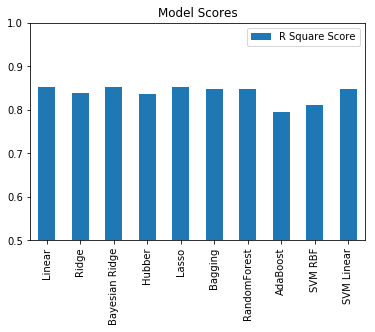

In [36]:
# R2 Score

def lets_try(train,labels):
    results={}
    def test_model(clf):
        
        cv = KFold(n_splits=5,shuffle=True,random_state=45)
        r2 = make_scorer(r2_score)
        r2_val_score = cross_val_score(clf, train, labels, cv=cv,scoring=r2)
        scores=[r2_val_score.mean()]
        return scores

    clf = linear_model.LinearRegression()
    results["Linear"]=test_model(clf)
    
    clf = linear_model.Ridge()
    results["Ridge"]=test_model(clf)
    
    clf = linear_model.BayesianRidge()
    results["Bayesian Ridge"]=test_model(clf)
    
    clf = linear_model.HuberRegressor()
    results["Hubber"]=test_model(clf)
    
    clf = linear_model.Lasso(alpha=1e-4)
    results["Lasso"]=test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"]=test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"]=test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"]=test_model(clf)
    
    clf = svm.SVR()
    results["SVM RBF"]=test_model(clf)
    
    clf = svm.SVR(kernel="linear")
    results["SVM Linear"]=test_model(clf)
    
    results = pd.DataFrame.from_dict(results,orient='index')
    results.columns=["R Square Score"] 
    #results=results.sort(columns=["R Square Score"],ascending=False)
    results.plot(kind="bar",title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0.5,1])
    return results

lets_try(data,labels)

,R Square Score
Linear,0.853790
Ridge,0.853826
Bayesian Ridge,0.853915
Hubber,0.859652
Lasso,0.853833
Bagging,0.739703
RandomForest,0.739960
AdaBoost,0.668070
SVM RBF,0.791613
SVM Linear,0.858283


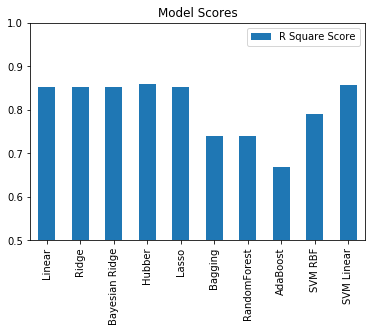

In [37]:
lets_try(dataPCA,labels)